# Cleaning and cannonizing DB


Author: AlvaroVM [https://alvarovm.github.io](http://alvarovm.github.io)
Version: 0.0.1

## Example 1: PCA to distinguish between rings and chains

For this example we define in SMILES string two groups of molecules with different substituents, such as -CH3, -O, -F, -Cl, and- I , in molecules with six carbons 1) in a ring and 2) in chain. Those molecules would be added to a list, additionally we add a 'certain' property , this could be used later as a flag.

In [1]:
import sys
import os
SRC_DIR='..'

In [2]:
sys.path.append(os.path.join(SRC_DIR, 'code'))
import utils

/home/vama/soft/python-tests/introtohpc/notebooks/../code/utils.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix
#https://github.com/jmcarpenter2/swifter
#import swifter
#2-TSNE-UMAP-map-cuda-Copy1

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs 
from rdkit.Chem import Draw
from rdkit.Chem.rdMolDescriptors import  GetHashedMorganFingerprint
from rdkit.DataStructs import ConvertToNumpyArray

from sklearn.manifold import TSNE

import hdbscan

utils.plot_settings2()

results_path = os.path.join(SRC_DIR,'results')

In [4]:
df = pd.read_pickle('../data/extended_db_Zindo_Nov_2019_V5_cannfp.pkl').fillna(value = 0)
print('Column names: {}'.format(str(df.columns.tolist())))
print('Table Shape: {}'.format(df.shape))


Column names: ['smiles', 'inchikey', 'fpfail', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent', 'nogood', 'nogoodp', 'mol', 'morganfps-b', 'morganfps-b8', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'molp', 'MolWt', 'MolWtp', 'MolWtdiff', 'gapdft', 'gapmopac']
Table Shape: (9870, 53)


In [5]:
df.count()

smiles                      9870
inchikey                    9870
fpfail                      9870
smi_pre                     9870
smi_post                    9870
lambda_sTDA (nm)            9870
f1_sTDA                     9870
lumo_dft                    9870
homo_dft                    9870
dmom_dft (D)                9870
lambda_z (nm)               9870
f1_z                        9870
lumo_z                      9870
homo_z                      9870
dmom_z (D)                  9870
lumo_mopac                  9870
homo_mopac                  9870
dmom_mopac (D)              9870
lambda_tddft (nm)           9870
f1_tddft                    9870
lambda_exp_max (nm)         9870
epsilon_exp_max             9870
lambda_exp_min (nm)         9870
epsilon_exp_min             9870
solvent                     9870
nogood                      9870
nogoodp                     9870
mol                         9870
morganfps-b                 9870
morganfps-b8                9870
NHOHCount 

In [6]:
len(df['lambda_exp_min (nm)'].tolist())

9870

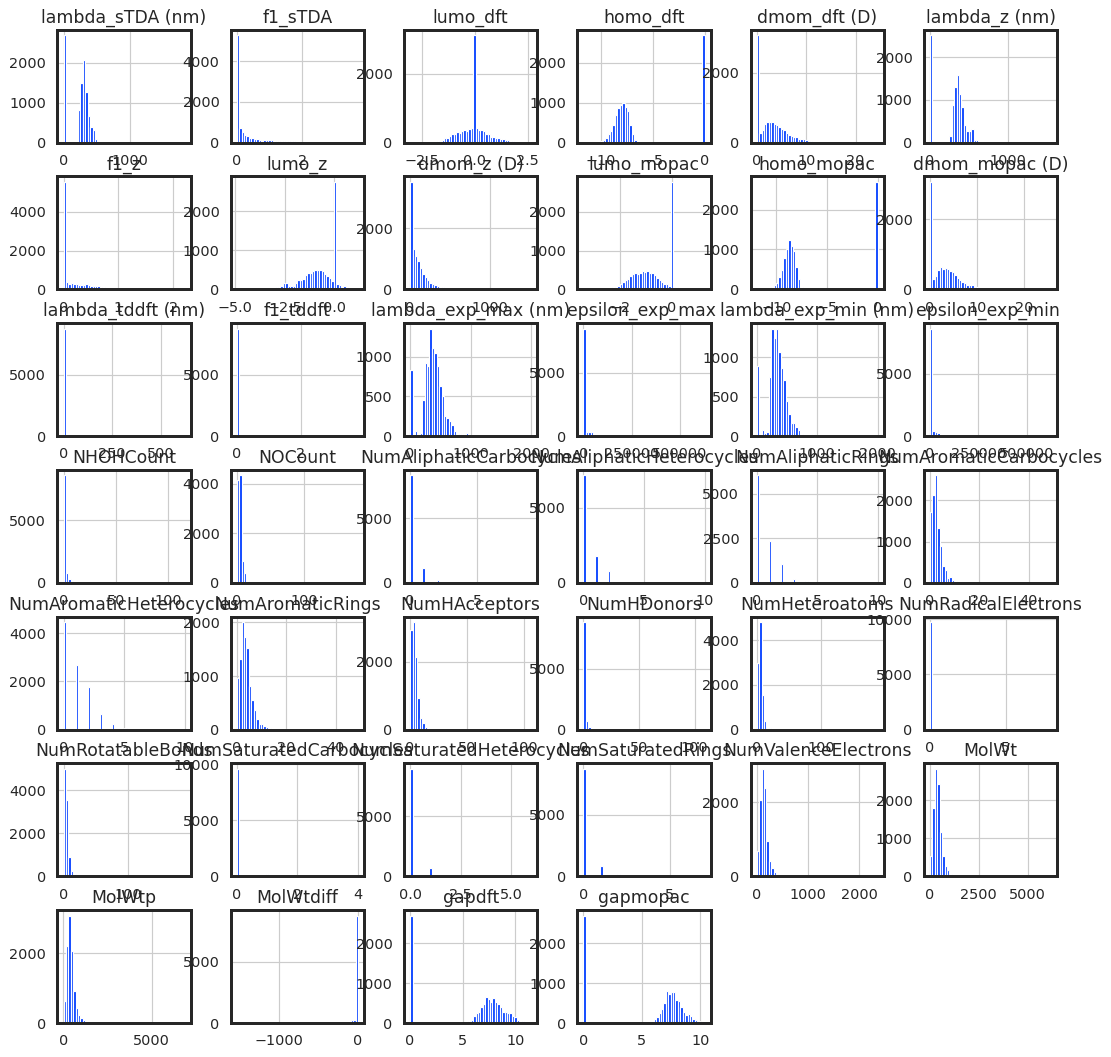

In [7]:
df.hist(bins=50, figsize=(15,15))
plt.show()

In [8]:
#tag='lambda_exp_max (nm)'
dfc=df.copy()
tag='lambda_sTDA (nm)'
dfc=dfc[dfc['lambda_sTDA (nm)']<1200]
dfc=dfc[dfc['lambda_sTDA (nm)']>630]
print('Table Shape: {}'.format(dfc.shape))

Table Shape: (26, 53)


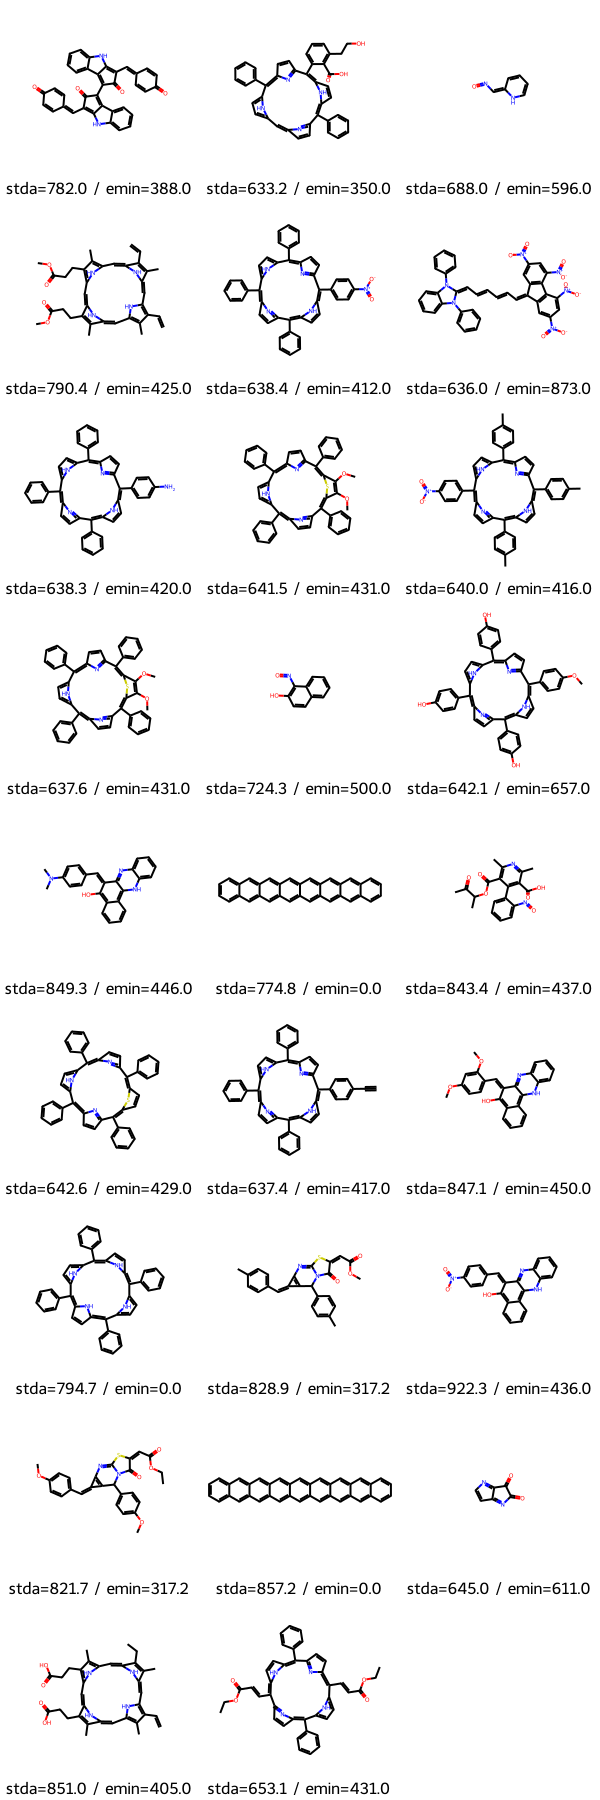

In [9]:
#tag='lambda_sTDA (nm)'
#tag='lambda_exp_min (nm)'
#x_index=get_list(index=df.index.tolist(), this=df[tag].tolist(), min=1220,max=1500)
#print(len(x_index))
mollist=dfc.mol.tolist()
#lam=df[tag][x_index].tolist()
#Draw.MolsToGridImage(mollist, legends=['min={0:.1f} exp{0:.1f}'.format(x,x) for x in x_index])
#Draw.MolsToGridImage(mollist, legends=['min={0:.1f} / expmin={1:.1f} / expmax={2:.1f} '.format(df['lambda_sTDA (nm)'][x],df['lambda_exp_min (nm)'][x],df['lambda_exp_max (nm)'][x]) for x in x_index])
#Draw.MolsToGridImage(mollist, legends=['stda={0:.1f} / expmin={1:.1f} '.format(dfc['lambda_sTDA (nm)'][x],dfc['lambda_exp_min (nm)'][x]) for x, row in dfc.iterrows()])
#Draw.MolsToGridImage(mollist, legends=['stda={0:.1f} / emax={1:.1f} '.format(dfc['lambda_sTDA (nm)'][x],dfc['lambda_exp_max (nm)'][x]) for x, row in dfc.iterrows()])
Draw.MolsToGridImage(mollist, legends=['stda={0:.1f} / emin={1:.1f} '.format(dfc['lambda_sTDA (nm)'][x],dfc['lambda_exp_min (nm)'][x]) for x, row in dfc.iterrows()])
#Draw.MolsToGridImage(mollist, legends=['tddft={0:.1f} / expmin={1:.1f} '.format(df['lambda_tddft (nm)'][x],df['lambda_exp_min (nm)'][x]) for x in x_index])
#Draw.MolsToGridImage(mollist, molsPerRow=5, subImgSize=(200,200), legends=[' expmin={0:.1f} / expmax={1:.1f} '.format(df['lambda_exp_min (nm)'][x],end='',df['lambda_exp_max (nm)'][x],end='') for x in x_index])

Table Shape: (2, 53)


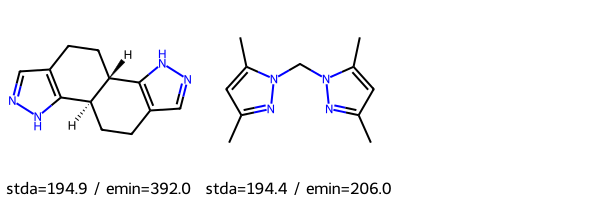

In [10]:
#tag='lambda_exp_max (nm)'
dfc=df.copy()
tag='lambda_sTDA (nm)'
dfc=dfc[dfc['lambda_sTDA (nm)']<200]
dfc=dfc[dfc['lambda_sTDA (nm)']>10]
print('Table Shape: {}'.format(dfc.shape))
mollist=dfc.mol.tolist()
Draw.MolsToGridImage(mollist, legends=['stda={0:.1f} / emin={1:.1f} '.format(dfc['lambda_sTDA (nm)'][x],dfc['lambda_exp_min (nm)'][x]) for x, row in dfc.iterrows()])
#Draw.MolsToGridImage(mollist, legends=['min={0:.1f} / exp={1:.1f} '.format(df['lambda_sTDA (nm)'][x],df['lambda_exp_min (nm)'][x]) for x in x_index])

/tmp/ipykernel_44121/2414185178.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df['lambda_exp_max (nm)'])
/tmp/ipykernel_44121/2414185178.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df['lambda_exp_min (nm)'])


<function matplotlib.pyplot.show(close=None, block=None)>

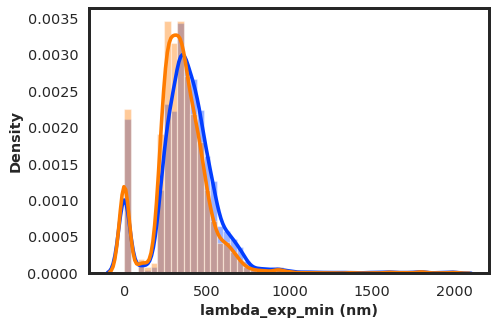

In [11]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.distplot( df['lambda_exp_max (nm)'])
sns.distplot( df['lambda_exp_min (nm)'])
plt.show

/tmp/ipykernel_44121/64297043.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['diffminmax'] > 1]['diffminmax'])


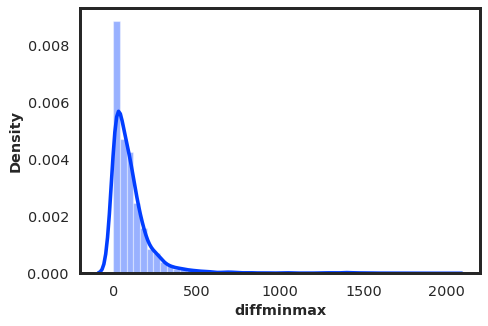

In [12]:
df['diffminmax']=df['lambda_exp_max (nm)']-df['lambda_exp_min (nm)']
plt.figure(figsize=(6,4))
#plt.hist(diffminmax,bins=100)
#df.head(2)
#print('Column names: {}'.format(str(df.columns.tolist())))
#df[df.diffminmax > 1].head(n=2)
sns.distplot(df[df['diffminmax'] > 1]['diffminmax'])
plt.show()
#df[df.diffminmax > 300]

/tmp/ipykernel_44121/1953314211.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['stdamin'] > 1]['stdamin'])


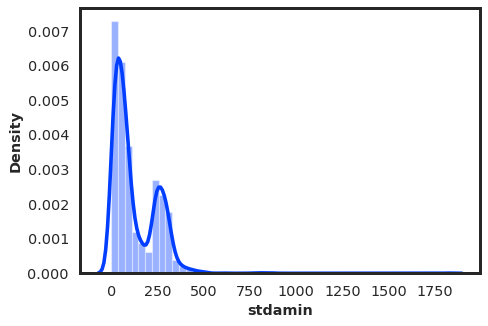

In [13]:
plt.figure(figsize=(6,4))
df['stdamin']=df['lambda_sTDA (nm)']-df['lambda_exp_min (nm)']
sns.distplot(df[df['stdamin'] > 1]['stdamin'])
plt.show()

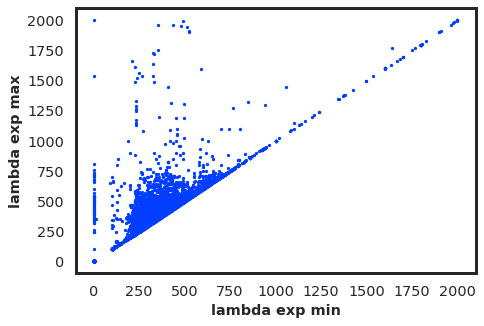

In [14]:
plt.figure(figsize=(6,4))
plt.scatter(df['lambda_exp_min (nm)'].values[:],df['lambda_exp_max (nm)'].values[:],s=3)
plt.xlabel('lambda exp min')
plt.ylabel('lambda exp max')
plt.show()

/tmp/ipykernel_44121/2905553733.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['lambda_exp_min (nm)'].values[:],df['lambda_sTDA (nm)'].values[:],s=40, cmap='winter')


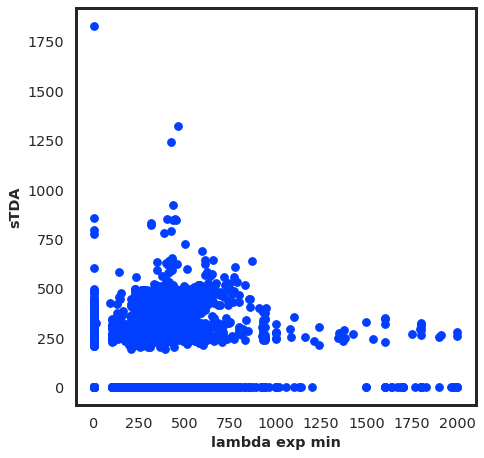

In [15]:
plt.figure(figsize=(6,6))
plt.scatter(df['lambda_exp_min (nm)'].values[:],df['lambda_sTDA (nm)'].values[:],s=40, cmap='winter')
plt.xlabel('lambda exp min')
plt.ylabel('sTDA')
#cbar = plt.colorbar(orientation='horizontal')
plt.show()

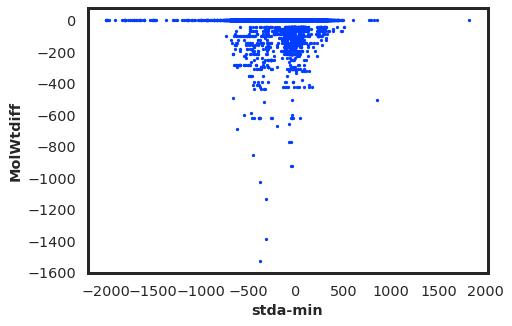

In [16]:
plt.figure(figsize=(6,4))
plt.scatter(df.stdamin,df.MolWtdiff,s=3)
plt.xlabel('stda-min')
plt.ylabel('MolWtdiff')
plt.show()

Remove metals and invalid smiles

In [17]:
#scketchmap-rdkit-102-isv-all-tsne-Copy1
#df=df[df['lambda_sTDA (nm)'] > 200]
#df=df[df['lambda_sTDA (nm)'] < 800]

dfc=df.copy()
tag='lambda_sTDA (nm)'
dfc=dfc[dfc['lambda_sTDA (nm)']>200]
dfc=dfc[dfc['lambda_sTDA (nm)']<800]

print('Table Shape: {}'.format(dfc.shape))

#df=df[df['lambda_tddft (nm)'] > 200]
#df=df[df['lambda_tddft (nm)'] < 800]
#df=df[df['lambda_exp_max (nm)'] > 200]
#df=df[df['lambda_exp_max (nm)'] < 800]

Table Shape: (7164, 55)


/tmp/ipykernel_44121/4075091650.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfc['lambda_sTDA (nm)'].tolist())


<Axes: ylabel='Density'>

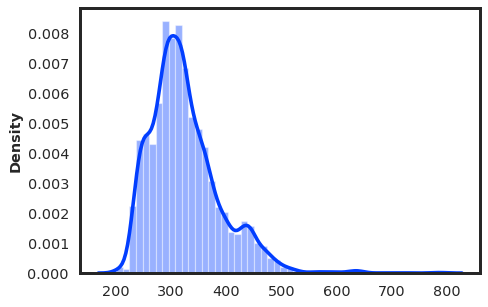

In [18]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.distplot(dfc['lambda_sTDA (nm)'].tolist())

/tmp/ipykernel_44121/857634185.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfc['lambda_exp_min (nm)'].tolist())
/tmp/ipykernel_44121/857634185.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfc['lambda_exp_max (nm)'].tolist())
/tmp/ipykernel_44121/857634185.py:5: UserWarning: 

`dis

<function matplotlib.pyplot.show(close=None, block=None)>

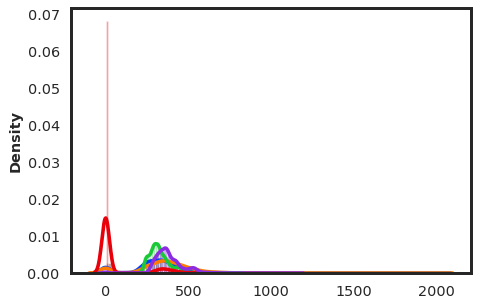

In [19]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.distplot(dfc['lambda_exp_min (nm)'].tolist())
sns.distplot(dfc['lambda_exp_max (nm)'].tolist())
sns.distplot(dfc['lambda_sTDA (nm)'].tolist())
sns.distplot(dfc['lambda_tddft (nm)'].tolist())
sns.distplot(dfc['lambda_z (nm)'].tolist())
plt.show

/tmp/ipykernel_44121/3996785324.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfc['stdaz'])


<Axes: xlabel='stdaz', ylabel='Density'>

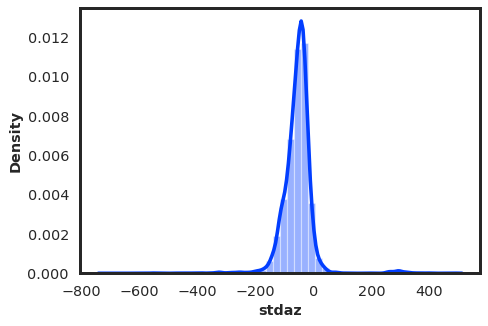

In [20]:
dfc['stdaz']=dfc['lambda_sTDA (nm)']-dfc['lambda_z (nm)']
plt.figure(figsize=(6,4))
sns.distplot(dfc['stdaz'])

In [21]:
dfz=dfc.copy()
dfz=dfz[dfz['lambda_z (nm)']>0]

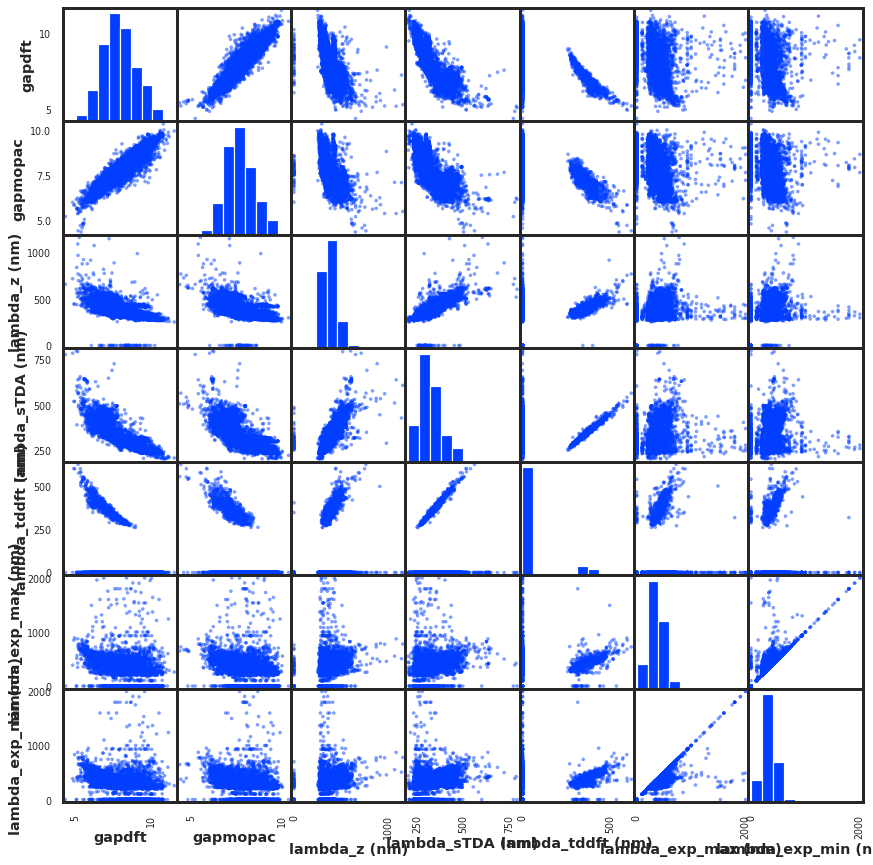

In [23]:
attributes = [ 'gapdft', 
               #'gapz', 
               'gapmopac',
               'lambda_z (nm)',
               'lambda_sTDA (nm)',
               'lambda_tddft (nm)', 
               'lambda_exp_max (nm)', 'lambda_exp_min (nm)']
scatter_matrix(dfc[attributes], figsize=(12, 12))
plt.show()

In [24]:
columns = { "gapdft":"GAP_DFT", 
               "gapz": "GAP_ZINDO",
           'gapmopac': "GAP_PM7",
          'lambda_z (nm)': "λ_ZINDO",
          'lambda_sTDA (nm)': "λ_sTDA",
           'lambda_tddft (nm)': "λ_TDDFT",
           'lambda_exp_max (nm)': "λ_Exp_Max", 
           'lambda_exp_min (nm)': "λ_Exp_Min"
          }

dfc.rename(columns, axis=1, inplace=True)


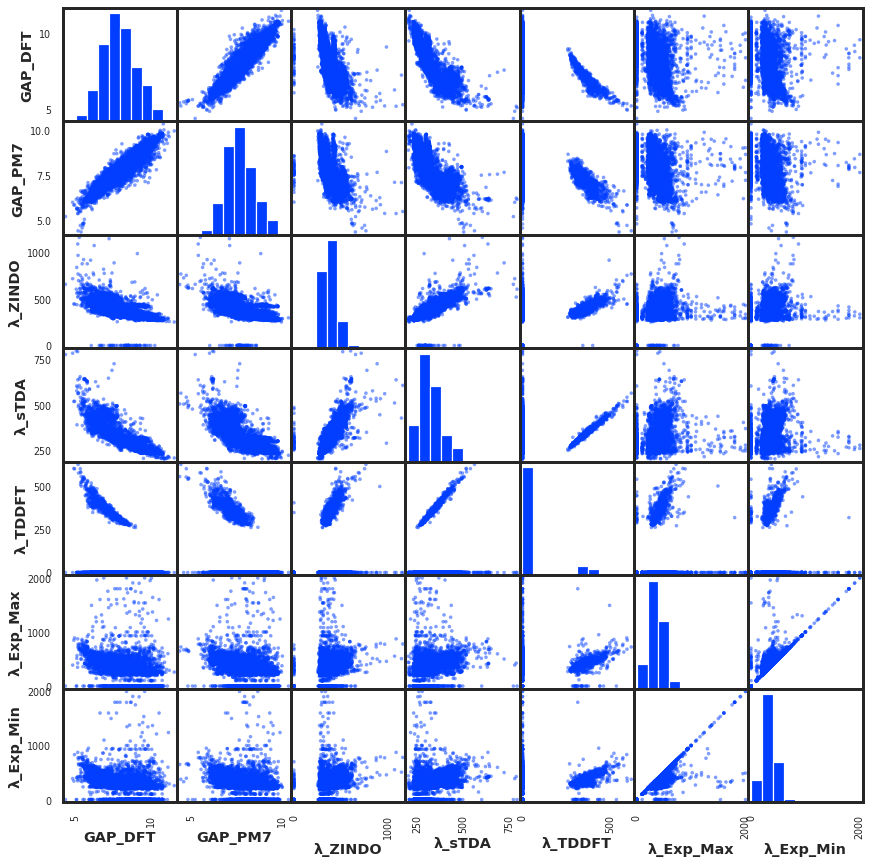

In [26]:
attributes = [ 'GAP_DFT', 
               #'GAP_ZINDO', 
               'GAP_PM7',
               'λ_ZINDO',
               'λ_sTDA',
               'λ_TDDFT', 
               'λ_Exp_Max', 
               'λ_Exp_Min']
scatter_matrix(dfc[attributes], figsize=(12, 12))
utils.save_figure(results_path,'gap-lambda-scatter_mat')
plt.show()

In [27]:
columns = { "epsilon_exp_max ":"ε_Exp_max",
           'f1_z':'f1_ZINDO',
           'f1_tddft':'f1_TDDFT'
          }

dfc.rename(columns, axis=1, inplace=True)


In [67]:
print('Column names: {}'.format(str(dfc.columns.tolist())))

Column names: ['smiles', 'inchikey', 'fpfail', 'smi_pre', 'smi_post', 'λ_sTDA', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'λ_ZINDO', 'f1_ZINDO', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'λ_TDDFT', 'f1_TDDFT', 'λ_Exp_Max', 'ε_Exp_max', 'λ_Exp_Min', 'epsilon_exp_min ', 'solvent', 'mol', 'morganfps-b', 'morganfps-b8', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'molp', 'MolWt', 'MolWtp', 'MolWtdiff', 'GAP_DFT', 'GAP_ZINDO', 'GAP_PM7', 'diffminmax', 'stdamin', 'stdaz']


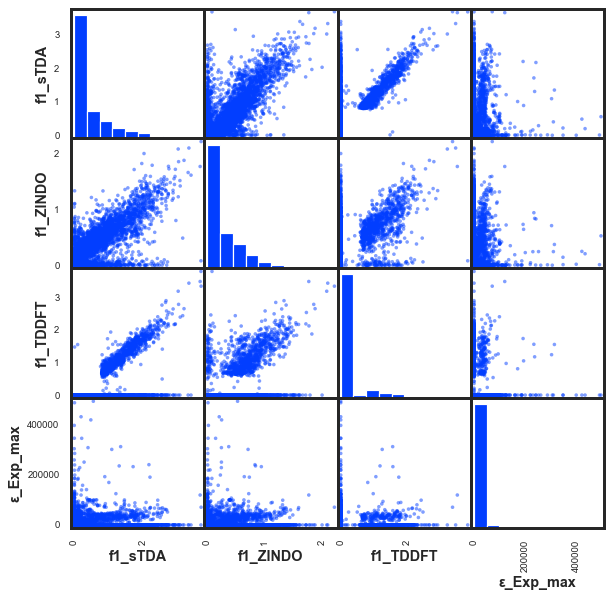

In [68]:


attributes = ['f1_sTDA',
              'f1_ZINDO',  
              'f1_TDDFT', 
               'ε_Exp_max']
scatter_matrix(dfc[attributes], figsize=(8, 8))
utils.save_figure(results_path,'f1_esps-scatter_mat')
plt.show()

Table Shape: (9858, 54)


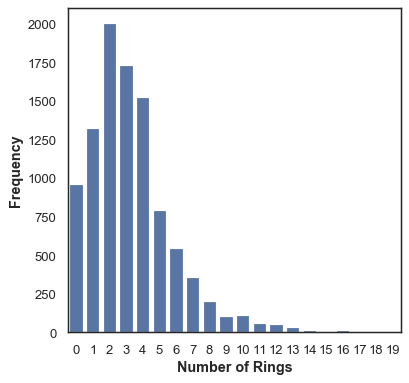

In [79]:
#tag='lambda_exp_max (nm)'
dfr=df.copy()
dfr=dfr[dfr['NumAromaticRings']<20]
print('Table Shape: {}'.format(dfr.shape))
#plt.figure(figsize=(6,4))
sns.set()
sns.set(style='white', palette='deep', font='sans-serif', font_scale=1., color_codes=True, rc=None)

this = dfr['NumAromaticRings'].value_counts()
plt.figure(figsize=(5,5))
sns.barplot(x=this.keys(), y=this.tolist(), color='b')
#plt.xlabel(r'Number Aromatic Rings in Molecule')
plt.xlabel(r'Number of Rings')
plt.ylabel('Frequency')
#plt.title('Number Aromatic Rings')

utils.save_figure(results_path,'NumAromaticRings')
plt.show()

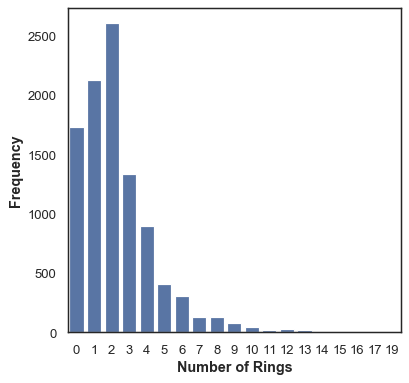

In [82]:
this = dfr['NumAromaticCarbocycles'].value_counts()
plt.figure(figsize=(5,5))
sns.barplot(x=this.keys(), y=this.tolist(),color='b')
#plt.xlabel(r'Number Aromatic Carbocycles in Molecule')
plt.xlabel(r'Number of Rings')
plt.ylabel('Frequency')
#plt.title('Number Aromatic Carbocycles')
utils.save_figure(results_path,'NumAromaticCarbocycles')


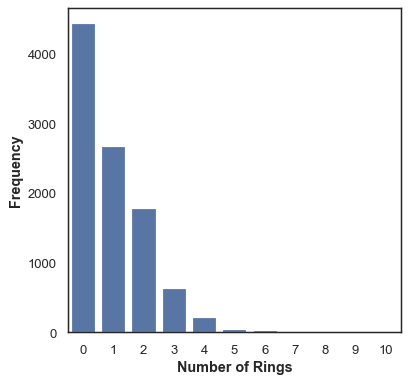

In [83]:
this = dfr['NumAromaticHeterocycles'].value_counts()
plt.figure(figsize=(5,5))
sns.barplot(x=this.keys(), y=this.tolist(),color='b')
#plt.xlabel(r'Number Aromatic Heterocycles in Molecule')
plt.ylabel('Frequency')
#plt.title('Number Aromatic Heterocycles')
plt.xlabel(r'Number of Rings')
utils.save_figure(results_path,'NumAromaticHeterocycles')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


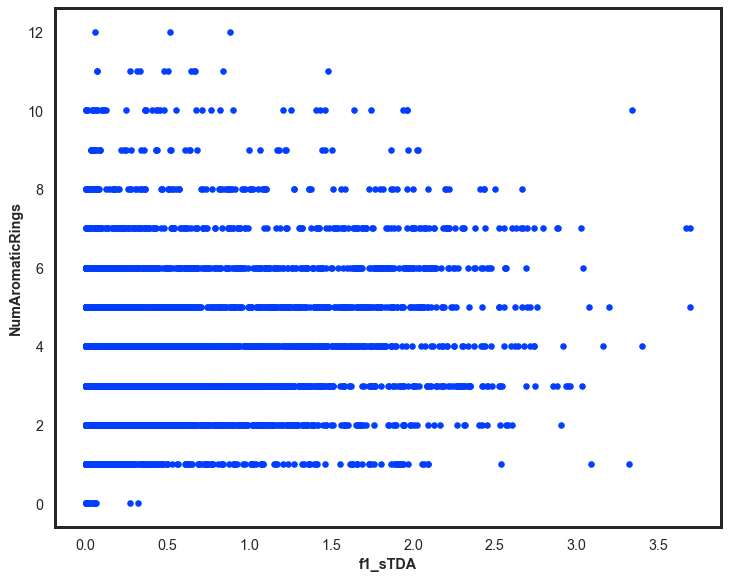

In [92]:
dfc.plot.scatter(x='f1_sTDA', y='NumAromaticRings')

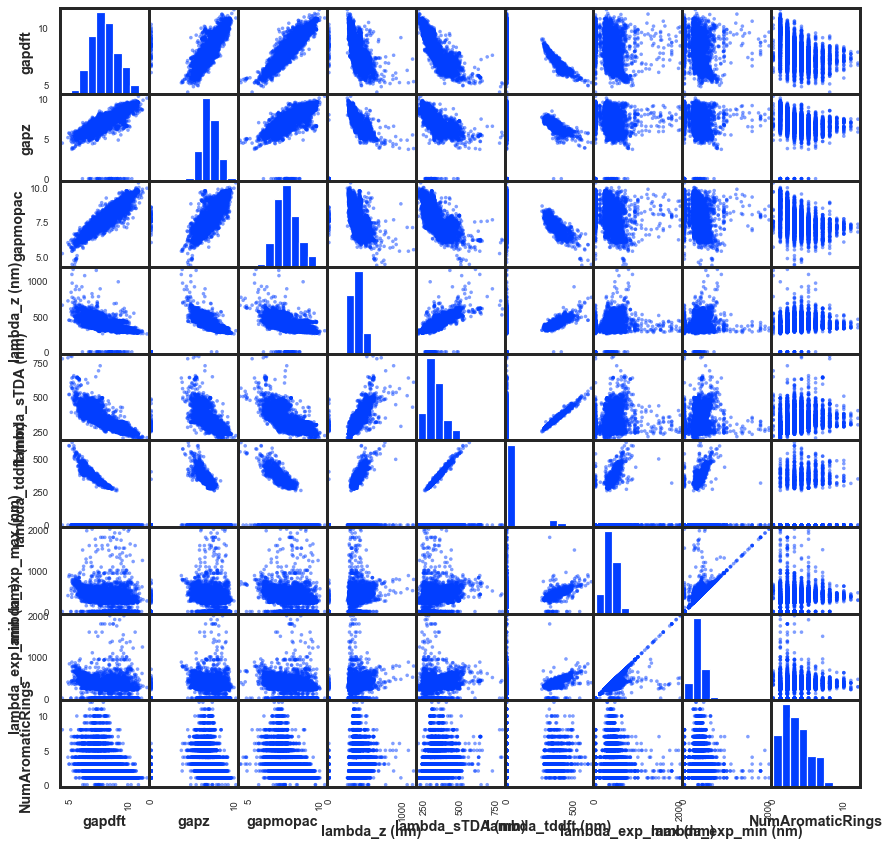

In [90]:
attributes = [ 'gapdft', 
               'gapz', 
               'gapmopac',
               'lambda_z (nm)',
               'lambda_sTDA (nm)',
               'lambda_tddft (nm)', 
               'lambda_exp_max (nm)', 
               'lambda_exp_min (nm)',
                'NumAromaticRings']
scatter_matrix(dfc[attributes], figsize=(12, 12))
plt.show()

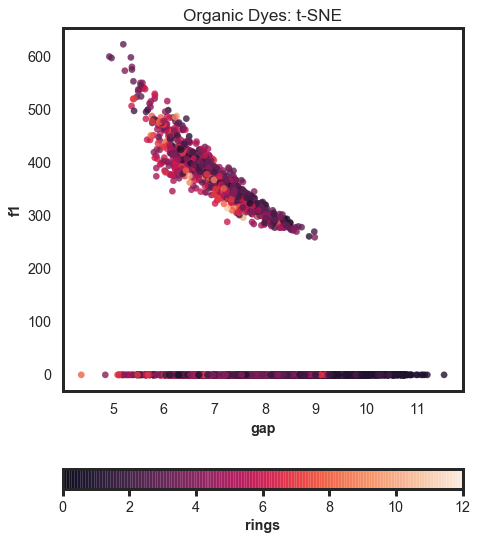

In [104]:
plt.figure(figsize=(6,8))
plot_kwds={'alpha':.8, 's':30, 'linewidths':.1}

#plt.scatter(tsne_X.T[0], tsne_X.T[1], c=df[ 'lambda_sTDA (nm)'].values[:], cmap='rainbow' )
plt.scatter(dfc['gapdft'].values[:], dfc[ 'lambda_tddft (nm)'].values[:], c=dfc[ 'NumAromaticRings'], **plot_kwds )

plt.xlabel('gap')
plt.ylabel('f1')
plt.title('Organic Dyes: t-SNE')

cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('rings')
plt.show()

In [260]:
#tag='lambda_exp_max (nm)'
dfr=df.copy()
tag='lambda_sTDA (nm)'
#dfr=dfr[dfr['lambda_sTDA (nm)']>0]
dfr=dfr[dfr['NumAromaticRings']>20]
print('Table Shape: {}'.format(dfr.shape))

Table Shape: (5, 54)


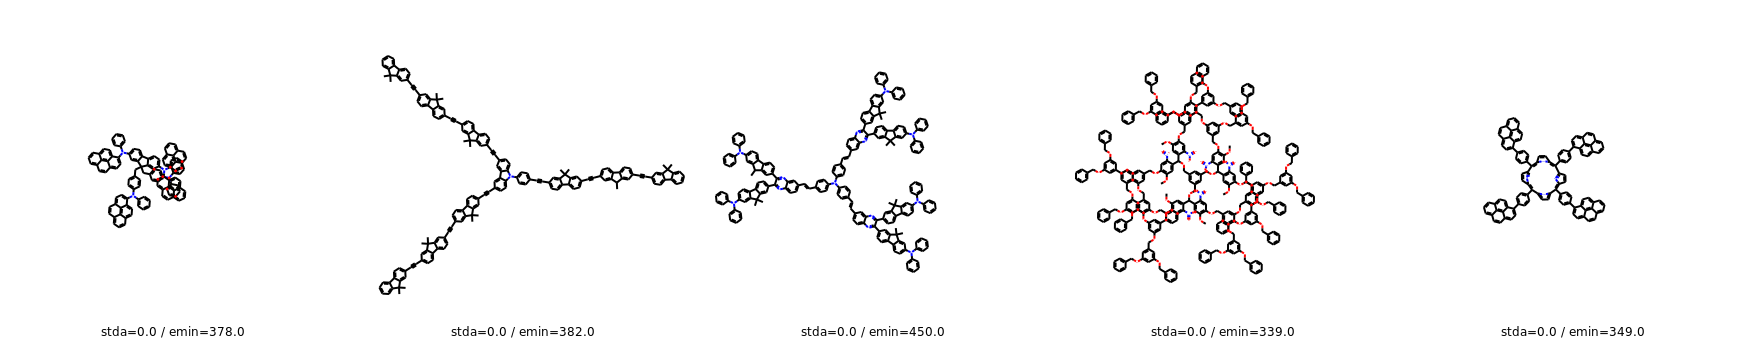

In [261]:
mollist = dfr.mol.tolist()
Draw.MolsToGridImage(mollist, molsPerRow=5, subImgSize=(350,350), legends=['stda={0:.1f} / emin={1:.1f} '.format(dfr['lambda_sTDA (nm)'][x],dfr['lambda_exp_min (nm)'][x]) for x, row in dfr.iterrows()])

In [139]:
#tag='lambda_exp_max (nm)'
dfr=df.copy()
dfr=dfr[dfr['lambda_z (nm)']>0]
dfr=dfr[dfr['NumAromaticRings']>10]
print('Table Shape: {}'.format(dfr.shape))


Table Shape: (15, 54)


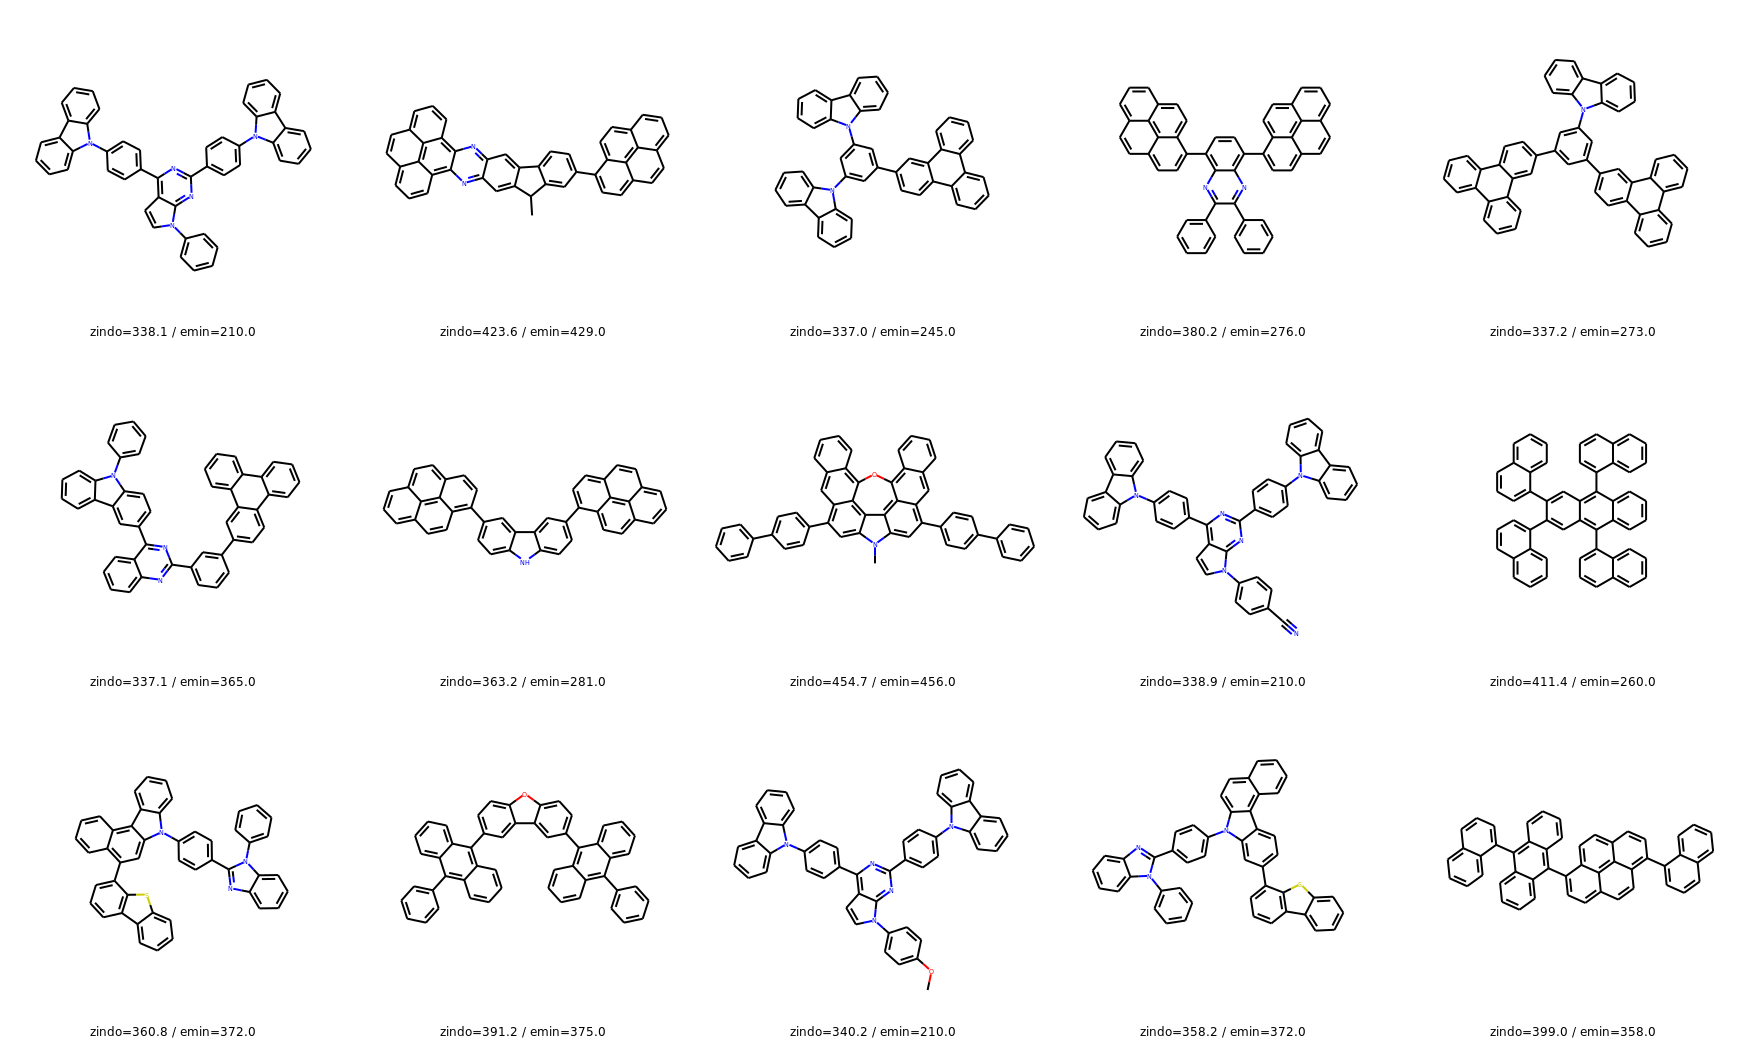

In [140]:
mollist = dfr.mol.tolist()
Draw.MolsToGridImage(mollist, molsPerRow=5, subImgSize=(350,350), legends=['zindo={0:.1f} / emin={1:.1f} '.format(dfr['lambda_z (nm)'][x],dfr['lambda_exp_min (nm)'][x]) for x, row in dfr.iterrows()])